In [61]:
import tensorflow as tf
import json
import os
import matplotlib.pyplot as plt

In [62]:
# Function to load COCO dataset annotations
def load_coco_annotations(annotations_file):
    with open(annotations_file, 'r') as f:
        annotations = json.load(f)
    return annotations

In [63]:
# Function to preprocess images and annotations
def preprocess_image_and_annotations(image_path, annotations, categories):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    # Convert annotations to a single label (e.g., majority class for simplicity)
    if annotations:
        label = categories[annotations[0]['category_id']]
    else:
        label = 0  # Assuming 0 is a valid class ID
    label = tf.convert_to_tensor(label, dtype=tf.int32)
    return image, label

In [64]:
# Function to load dataset
def load_dataset(dataset_dir, split):
    split_dir = os.path.join(dataset_dir, split)
    annotations_file = os.path.join(split_dir, '_annotations.coco.json')
    annotations = load_coco_annotations(annotations_file)
    categories = {category['id']: i for i, category in enumerate(annotations['categories'])}
    category_names = {i: category['name'] for i, category in enumerate(annotations['categories'])}
    images = {image['id']: image for image in annotations['images']}
    image_paths = [os.path.join(split_dir, image['file_name']) for image in images.values()]
    image_annotations = {image['file_name']: [] for image in images.values()}
    for annotation in annotations['annotations']:
        image_id = annotation['image_id']
        file_name = images[image_id]['file_name']
        image_annotations[file_name].append(annotation)
    return image_paths, image_annotations, categories, category_names

In [65]:
# Path to the dataset directory
dataset_dir = 'dataset'

In [66]:
# Load train, valid, and test datasets
train_image_paths, train_annotations, categories, category_names = load_dataset(dataset_dir, 'train')
valid_image_paths, valid_annotations, _, _ = load_dataset(dataset_dir, 'valid')
test_image_paths, test_annotations, _, _ = load_dataset(dataset_dir, 'test')

In [67]:
# Create TensorFlow datasets
def create_tf_dataset(image_paths, annotations, categories):
    def generator():
        for image_path in image_paths:
            image_name = os.path.basename(image_path)
            image_data = tf.io.read_file(image_path)
            image = tf.image.decode_jpeg(image_data, channels=3)
            image = tf.image.resize(image, [128, 128])
            annotation = annotations.get(image_name, [])
            if annotation:
                label = categories[annotation[0]['category_id']]
            else:
                label = 0  # Assuming 0 is a valid class ID
            yield image, label
    
    dataset = tf.data.Dataset.from_generator(generator, output_signature=(
        tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)))
    return dataset

In [68]:
train_dataset = create_tf_dataset(train_image_paths, train_annotations, categories)
valid_dataset = create_tf_dataset(valid_image_paths, valid_annotations, categories)
test_dataset = create_tf_dataset(test_image_paths, test_annotations, categories)

In [69]:
# Batch and shuffle the datasets
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)
valid_dataset = valid_dataset.batch(32)
test_dataset = test_dataset.batch(32)

In [70]:
# Define a simple CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(categories), activation='softmax')  # Adjust based on number of classes
])

In [71]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [72]:
# Train the model
history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 393ms/step - accuracy: 0.1135 - loss: 143.4338 - val_accuracy: 0.1667 - val_loss: 118.1587
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - accuracy: 0.0854 - loss: 92.9469 - val_accuracy: 0.1667 - val_loss: 19.4451
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - accuracy: 0.0875 - loss: 19.2832 - val_accuracy: 0.0417 - val_loss: 3.5390
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - accuracy: 0.2719 - loss: 2.3549 - val_accuracy: 0.3750 - val_loss: 1.6303
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - accuracy: 0.4615 - loss: 1.4335 - val_accuracy: 0.4583 - val_loss: 1.3592
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - accuracy: 0.7823 - loss: 0.8546 - val_accuracy: 0.6250 - val_loss: 1.1827
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step - accuracy: 0.7792 - loss: 0.5583 - val_accuracy: 0.6250 - val_loss: 1.4610
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step - accuracy: 0.8583 - loss: 0.5532 - val_accuracy: 0.6250 - va

In [73]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7500 - loss: 2.5209
Test accuracy: 0.75


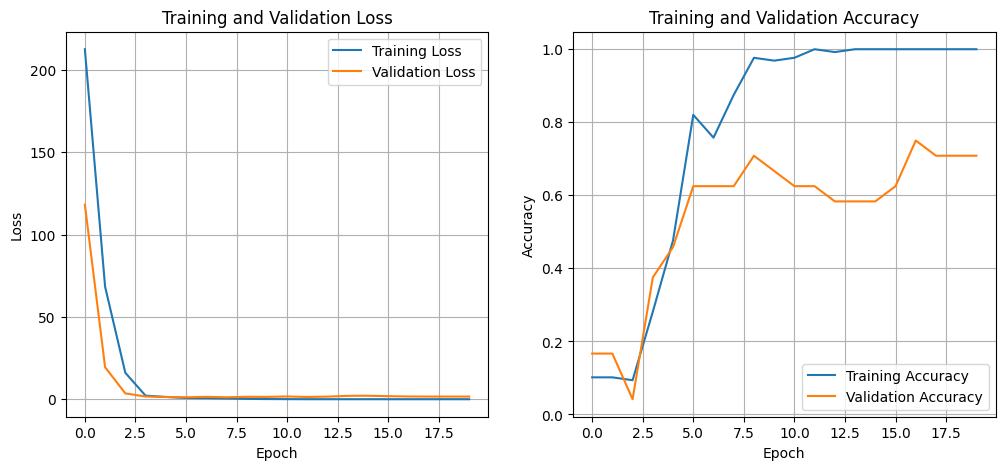

In [74]:
# Plot training and validation loss
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.show()

plot_training_history(history)

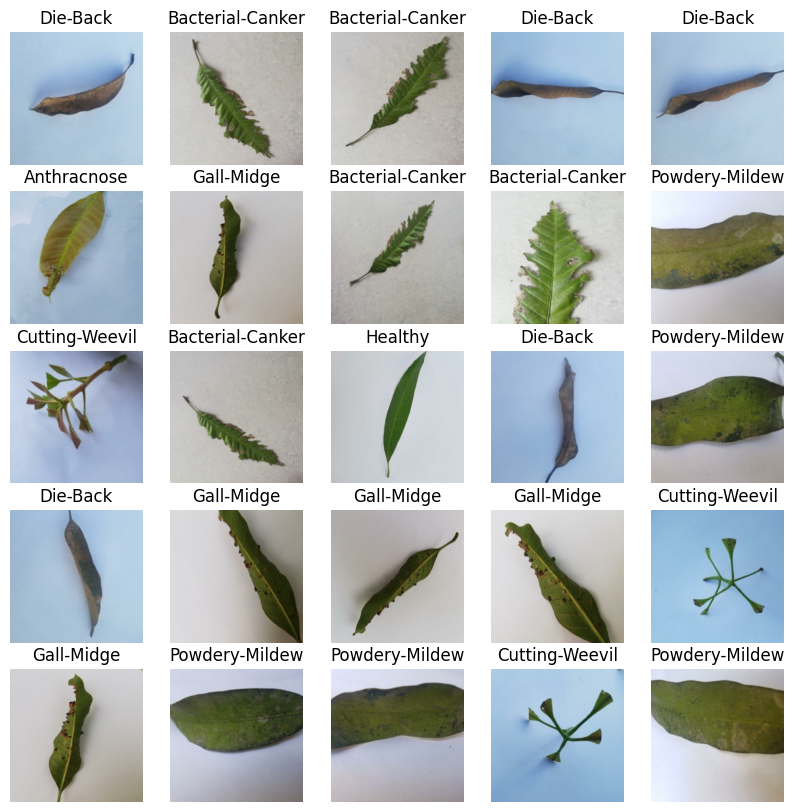

In [75]:
# Visualization of the dataset
def plot_images_with_labels(image_paths, annotations, categories, category_names, num_images=25):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        image_path = image_paths[i]
        image_name = os.path.basename(image_path)
        annotation = annotations.get(image_name, [])
        if annotation:
            label = categories[annotation[0]['category_id']]
            label_name = category_names[label]
        else:
            label_name = "Unknown"
        
        image_data = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image_data, channels=3)
        
        plt.subplot(5, 5, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(label_name)
        plt.axis("off")
    plt.show()

# Plot some images with labels from the training dataset
plot_images_with_labels(train_image_paths, train_annotations, categories, category_names)